In [1]:
# setting the random seed for reproducibility
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd
import numpy as np
from datetime import datetime

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(style="whitegrid")
from IPython.display import Image

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from scipy import signal
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA

# # to print out all the outputs of the cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# set display options
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# read the time series data set
df =  pd.read_csv('../data/teleco_time_series.csv')

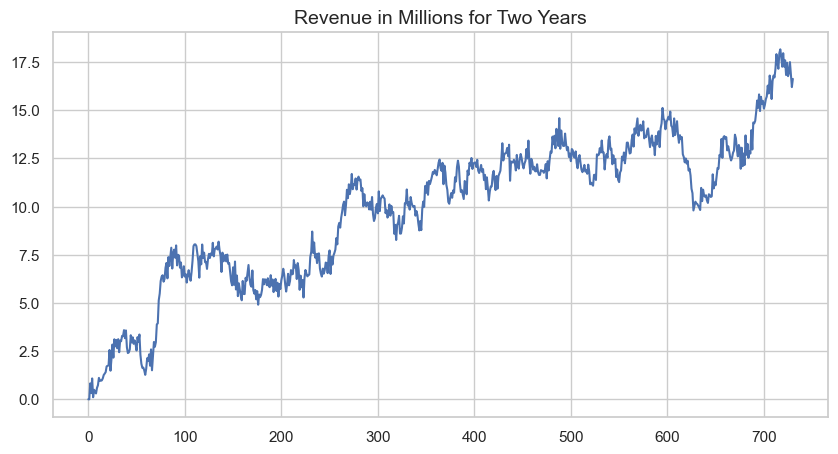

In [3]:
# plotting the realization of the time series
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Revenue'])
plt.title('Revenue in Millions for Two Years', fontsize=14)
plt.show()

In [4]:
# drop zero values
df= df[df['Revenue'] != 0]

In [5]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Day,0,0.0,0,0.0,0,0.0
Revenue,0,0.0,0,0.0,0,0.0


In [6]:
# add Date column
df['Date'] = pd.date_range(start = datetime(2019,1,1),
                           periods = df.shape[0],
                           freq = '24H'
                          )

# set Date column as index
df.set_index('Date', inplace=True)
df.drop(columns=['Day'], inplace=True)

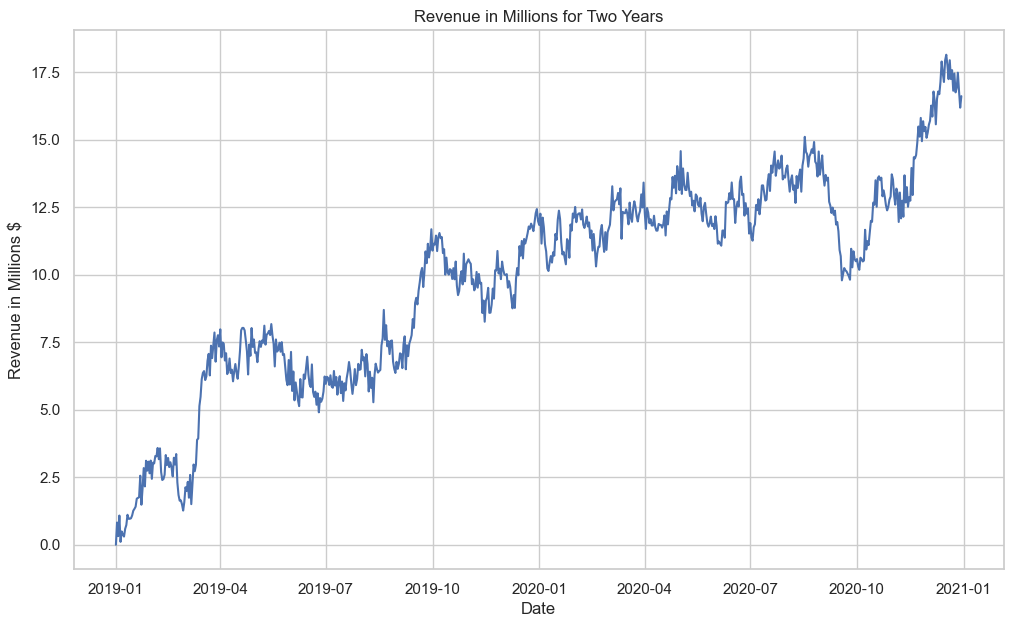

In [7]:
plt.figure(figsize=(12,7))
plt.plot(df.Revenue)
plt.title('Revenue in Millions for Two Years')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions $')
plt.show()

In [8]:
result = adfuller(df['Revenue'])
print('Test statistics: ', result[0])
print('P-value: ', result[1])
print('Critical value: ', result[4])
print('----------------------------------------------------------------------------------------------')

if result[1] >= 0.05:
    print('Reject the null hypothesis. The time series is stationary. No further action required.')
else:
    print('Fail to reject the null hypothesis. The time series is not stationary. You must make it so.')

Test statistics:  -1.7746383121968732
P-value:  0.3931237595029723
Critical value:  {'1%': -3.4393644334758475, '5%': -2.8655182850048306, '10%': -2.568888486973192}
----------------------------------------------------------------------------------------------
Reject the null hypothesis. The time series is stationary. No further action required.


In [9]:
# use the last 30 days for testing
train = df.iloc[:-30]
test = df.iloc[-30:]
print('Training set: {}'.format(train.shape))
print('Testing set: {}'.format(test.shape))

Training set: (700, 1)
Testing set: (30, 1)


In [10]:
# save the cleaned data set
df.to_csv('../data/teleco_cleaned1.csv', index=False)
train.to_csv('../data/teleco_cleaned1_train.csv', index=False)
test.to_csv('../data/teleco_cleaned1_test.csv', index=False)

In [11]:
model1 = seasonal_decompose(df['Revenue'], model='multiplicable', period=12)

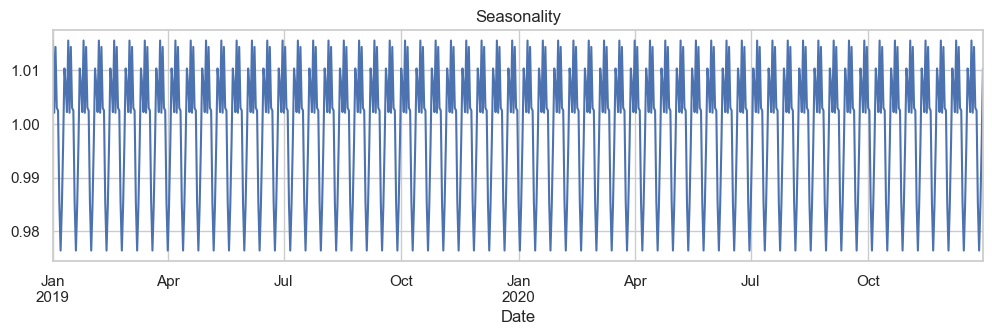

In [12]:
plt.title('Seasonality')
model1.seasonal.plot(figsize=(12, 3))
plt.show()

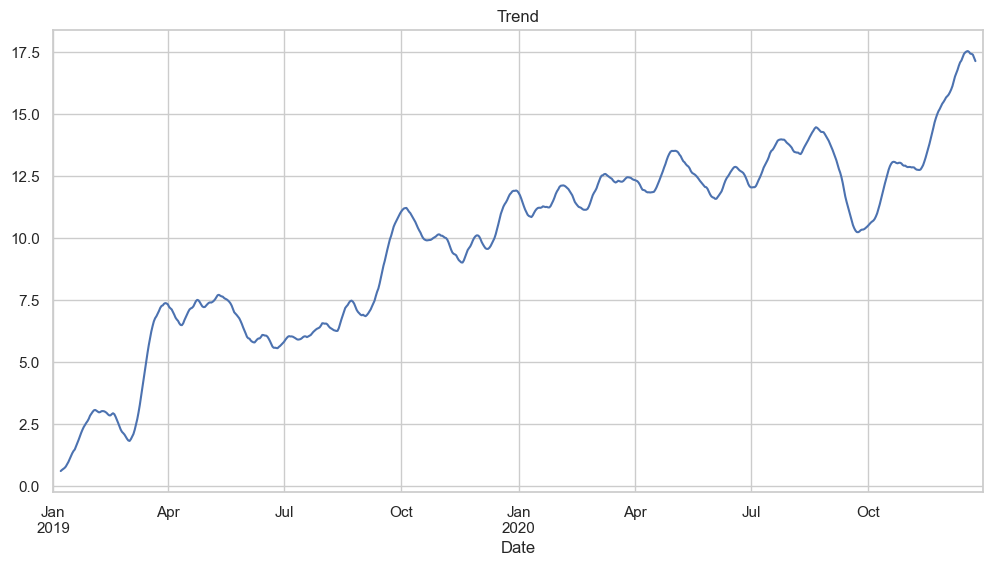

In [13]:
plt.figure(figsize=(12,6))
plt.title('Trend')
model1.trend.plot()
plt.show()

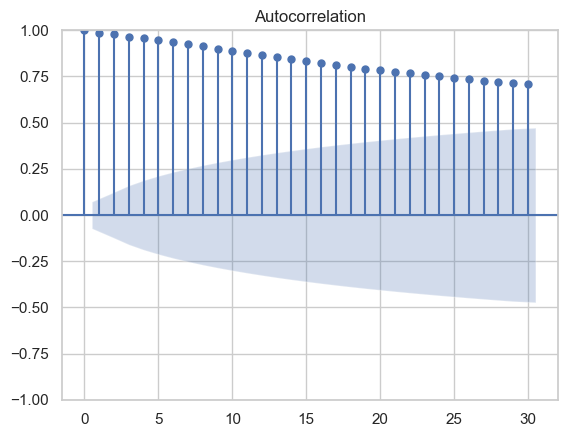

In [14]:
# calculate acf
acf_values = acf(df['Revenue'])
# keeping lag as 30
plot_acf(df['Revenue'], lags=30);
plt.show()

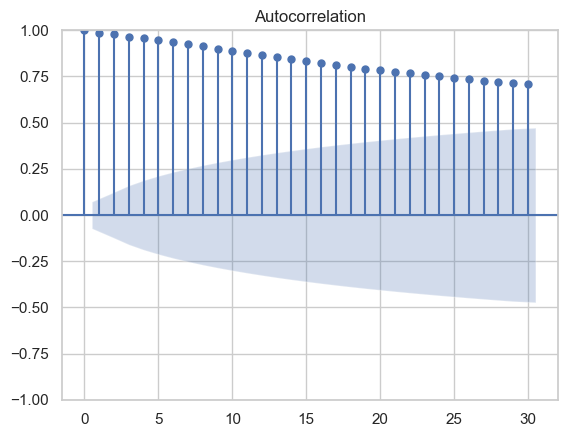

In [15]:
# calculate acf
acf_values = acf(df['Revenue'])
# keeping lag as 30
plot_acf(df['Revenue'], lags=30);
plt.show()

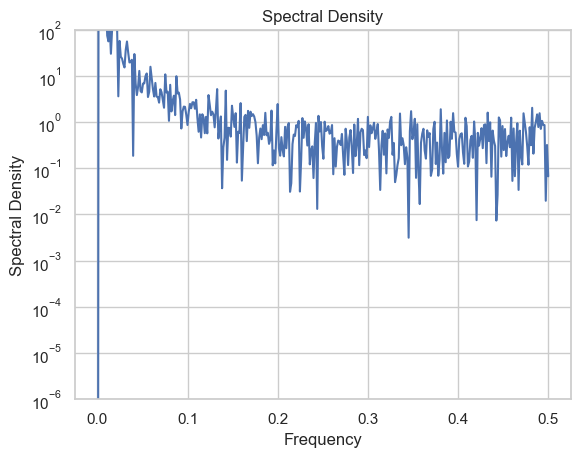

In [16]:
f, Pxx_den = signal.periodogram(df['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim(1e-6, 1e2)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

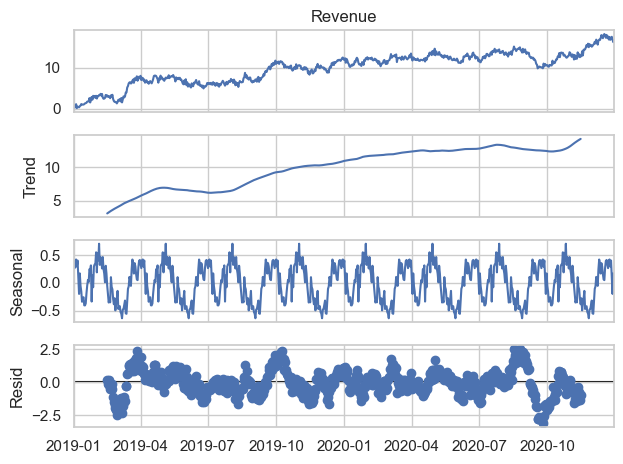

In [17]:
decomp = seasonal_decompose(df['Revenue'], period=90)
decomp.plot()
plt.show()

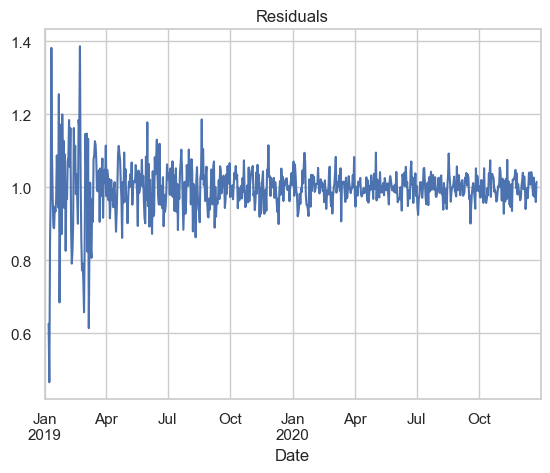

In [18]:
plt.title('Residuals')
model1.resid.plot()
plt.show()

In [19]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.02237291702715709, False)

In [20]:
# model2=auto_arima(train,start_p=0,d=1,start_q=0,
#           max_p=5,max_d=5,max_q=5, start_P=0,
#           D=1, start_Q=0, max_P=5,max_D=5,
#           max_Q=5, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=493,n_fits=50)

In [22]:
# model2.summary()

In [23]:
# create final model 
model3 = ARIMA(df['Revenue'], order=(1,1,0), seasonal_order=(5, 1, 0, 12))
final_model = model3.fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          Revenue   No. Observations:                  730
Model:             ARIMA(1, 1, 0)x(5, 1, 0, 12)   Log Likelihood                -535.993
Date:                          Thu, 31 Aug 2023   AIC                           1085.987
Time:                                  13:23:53   BIC                           1118.012
Sample:                              01-01-2019   HQIC                          1098.353
                                   - 12-30-2020                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4781      0.034    -14.173      0.000      -0.544      -0.412
ar.S.L12      -0.8591      0.039    -22.126      0.000      -0.935      -0.783
ar.S.L24      -0.7058      0.052    -13.577      0.000      -0.808      -0.604
ar.S.L36      -0.4672      0.058     -8.071      0.000      -0.581      -0.354
ar.S.L48      -0.3017      0.050     -6.017      0.000      -0.400      -0.203
ar.S.L60      -0.1672      0.039     -4.304      0.000      -0.243      -0.091
sigma2         0.2565      0.015     17.414      0.000       0.228       0.285
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.95   Prob(JB):                         0.35
Heteroskedasticity (H):               1.08   Skew:                             0.00
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
index_future_dates = pd.date_range(start='2020-12-01', end='2020-12-30')
print(index_future_dates)

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', freq='D')


In [25]:
predictions = final_model.predict(start=len(df), end=len(df)+29, typ='levels')

predictions.index = index_future_dates
print(predictions)

2020-12-01    16.594268
2020-12-02    16.201477
2020-12-03    16.416889
2020-12-04    16.375951
2020-12-05    16.497808
2020-12-06    16.215819
2020-12-07    16.601740
2020-12-08    16.464448
2020-12-09    16.659518
2020-12-10    16.859056
2020-12-11    17.032650
2020-12-12    17.195227
2020-12-13    17.189922
2020-12-14    16.697272
2020-12-15    16.955515
2020-12-16    17.086065
2020-12-17    17.123561
2020-12-18    16.911494
2020-12-19    17.440188
2020-12-20    17.226752
2020-12-21    17.413404
2020-12-22    17.581965
2020-12-23    17.832530
2020-12-24    17.763408
2020-12-25    17.766160
2020-12-26    17.422238
2020-12-27    17.640157
2020-12-28    17.704545
2020-12-29    17.754207
2020-12-30    17.687338
Freq: D, Name: predicted_mean, dtype: float64


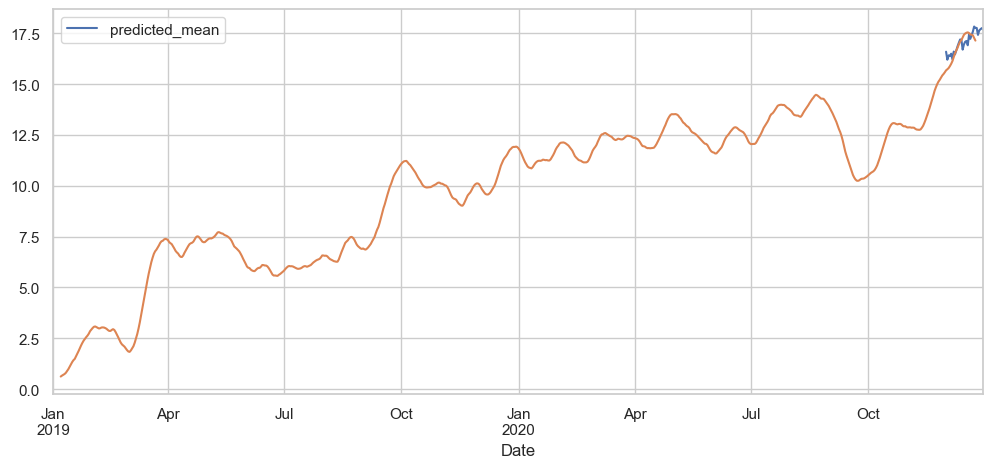

In [26]:
plt.figure(figsize=(12,5))
predictions.plot(legend=True)
model1.trend.plot()
plt.show()

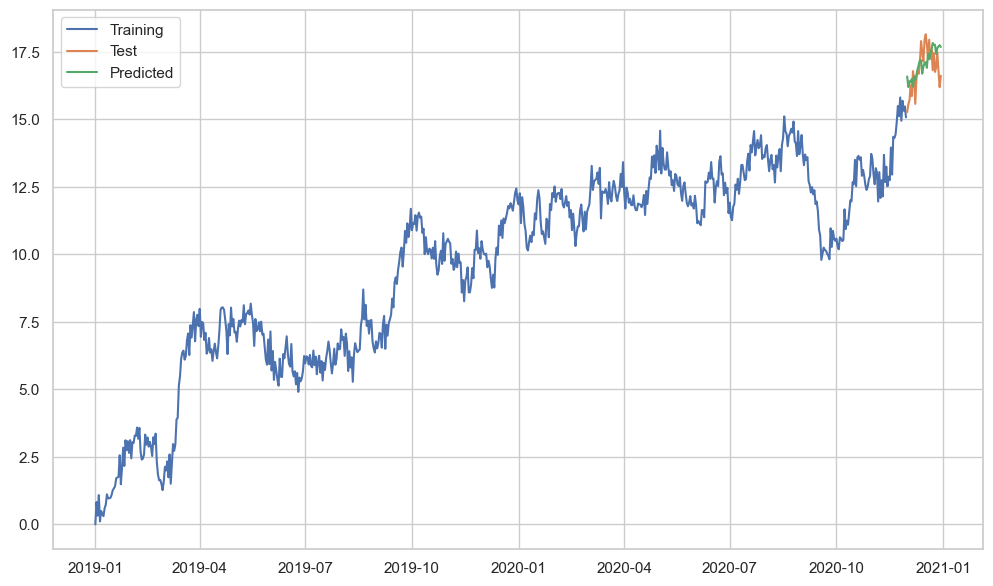

In [27]:
plt.figure(figsize=(12,7))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(predictions,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [28]:
test['predicted_revenue'] = predictions
r2_score(test['Revenue'], test['predicted_revenue'])

# R2 Score for test data set

0.11777423873372961

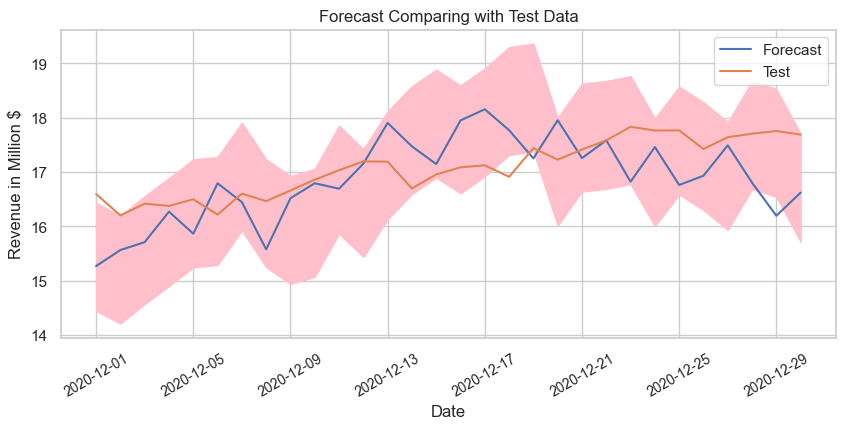

In [41]:
predictions = final_model.get_prediction(start=len(df)-30, end=len(df)-1)
ci = predictions.conf_int()
ll = ci.loc[:, 'lower Revenue']
ul = ci.loc[:, 'upper Revenue']

plt.figure(figsize=(10,4))
plt.title('Forecast Comparing with Test Data')
plt.xlabel('Date')
plt.ylabel('Revenue in Million $')
plt.xticks(rotation=30, fontsize=10)
lines=plt.plot(test.index, test)
plt.fill_between(ll.index, ll, ul, color='pink')
plt.legend(lines[:2], ['Forecast', 'Test']);

In [ ]:
print('Successful run!')